In [1]:
import numpy as np
import pandas as pd

# Inspecting the split output files

In [2]:
%%bash
ls -l "/mnt/project/outputs/gnomad_pass_variants/split_pass_variants/" > pass_files.txt

In [20]:
df = (pd.read_csv("./pass_files.txt",
                  delim_whitespace=True, 
                  skiprows=1, 
                  header=None, 
                  names=["a","b","c","d","file_size","e","f","g","file_name"], 
                 )
     )
df = df[["file_name","file_size"]]
df.head(3)

,file_name,file_size
0,ukb24068_c10_b0_v1_snps_pass.tsv,5880
1,ukb24068_c10_b1000_v1_snps_pass.tsv,4989
2,ukb24068_c10_b1001_v1_snps_pass.tsv,11108


In [21]:
df.shape

(37095, 2)

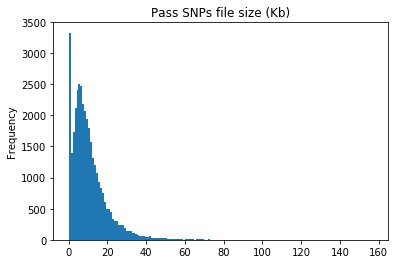

In [22]:
(df.file_size/1000).plot(kind="hist", bins=155, title="Pass SNPs file size (Kb)")

In [23]:
a = df.file_size.sum()/1000000
print(f"Sum of file sizes: {int(a)} Mb")
print(f"Number of empty files: {len(df[df.file_size==0])}")

Sum of file sizes: 389 Mb
Number of empty files: 2493


# Inspecting the pass variants

In [51]:
df = (pd.read_csv("/mnt/project/outputs/gnomad_pass_variants/all_pass_snvs.txt", 
                  sep="\t", 
                  header=None,
                  names=["chr","pos","id","ref","alt","qual","filter","info","ac","an"]
                 )
     )

In [52]:
df.shape

(10836767, 10)

In [54]:
df.drop_duplicates(["chr","pos","ref","alt"]).shape

(10836767, 10)

# Getting VEP annotations

In [31]:
vep = pd.read_csv("/mnt/project/data/vep_cds_all_possible_snvs.vcf", sep="\t", nrows = 10, header=None, comment="#")

In [35]:
# Retreive VEP annotations of all possible SNVs
vep = pd.read_csv(
    "/mnt/project/data/vep_cds_all_possible_snvs.vcf",
    sep="\t",
    comment="#",
    header=None,
    names=["chr","pos","id","ref","alt","qual","filter","info"],
    usecols=["chr", "pos", "ref", "alt", "info"],
)

In [37]:
# Get enst
vep["enst"] = pd.Series([x.split("|", 3)[2] for x in vep["info"]])

In [38]:
# Get csq
syn = pd.Series(["synonymous" in x for x in vep["info"]])
mis = pd.Series(["missense" in x for x in vep["info"]])
non = pd.Series(["stop_gained" in x for x in vep["info"]])

vep.loc[syn, "csq"] = "synonymous"
vep.loc[mis, "csq"] = "missense"
vep.loc[non, "csq"] = "nonsense"

vep = vep.drop("info", axis=1).dropna()  # Keep only syn/mis/non variants

In [44]:
vep.csq.value_counts()

missense      73231288
synonymous    23099124
nonsense       4146609
Name: csq, dtype: int64

In [45]:
vep.csq.isna().sum()

0

In [49]:
vep.duplicated(["chr","pos","ref","alt"]).sum()

0

# Merging with VEP

In [58]:
df = df.merge(vep, how="left")
df = df.drop(["id","qual","filter","info"], axis=1)

In [60]:
df.csq.value_counts()

missense      7219559
synonymous    3359955
nonsense       236717
Name: csq, dtype: int64

In [61]:
df[df.ac==1].csq.value_counts()

missense      3452755
synonymous    1464049
nonsense       127971
Name: csq, dtype: int64

In [63]:
df[(df.ac / df.an) <0.001].csq.value_counts()

missense      7150961
synonymous    3299180
nonsense       235974
Name: csq, dtype: int64